# 00_Figures

In [1]:
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from matplotlib import cm
from pylab import rcParams

In [2]:
colors = {
    'DE2': '#97e876',
    'DE1': '#4a004b',
    'InterVE': '#ff8d4c',
    'Foregut': '#7da2ff',
    'Hindgut2': '#003d92',
    'FP': '#fa6151',
    'Hindgut1': '#ac4ebf',
    'PS2': '#00b46e',
    'Notochord': '#dfd86e',
    'Liver': '#bd006d',
    'Node': '#7067df',
    'AVE': '#3f9a24',
    'Midgut': '#ff6cc8',
    'ExVE1': '#9fbc2d',
    'ExVE2': '#ce6f0b',
    'EmVE': '#ebb8ff',
    'PS1': '#890033',
    'PE': '#ff7d7c'
}

/opt/conda/envs/cellrank-1.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  """Entry point for launching an IPython kernel.


House keeping genes taken from https://housekeeping.unicamp.br/?homePageGlobal

In [3]:
# !date
# !wget https://housekeeping.unicamp.br/Housekeeping_GenesMouse.csv -O ../data/raw/Housekeeping_GenesMouse.csv

In [4]:
house_genes = pd.read_csv(
    "../data/raw/Housekeeping_GenesMouse.csv", sep=";", index_col=1
)
house_genes

,Ensembl ID,Chromosome_scaffold,Transcript start,Transcript end
Gene,,,,
0610009B22Rik,ENSMUST00000007921,11,51685386,51688653
0610030E20Rik,ENSMUST00000077783,6,72347334,72353148
0610030E20Rik,ENSMUST00000192144,CHR_MG184_PATCH,72347333,72353147
0610037L13Rik,ENSMUST00000125107,4,107889899,107897802
0610037L13Rik,ENSMUST00000106727,4,107889863,107897118
...,...,...,...,...
Zxdb,ENSMUST00000101388,X,94724569,94730187
Zxdc,ENSMUST00000113539,6,90369492,90385084
Zxdc,ENSMUST00000203493,6,90369613,90383103


# Load data

In [5]:
vivo = sc.read("../data/processed/01_raw_counts.h5ad")

metadata = pd.read_csv("../data/processed/02_metadata.csv", index_col=0)
vivo = vivo[metadata.index]
vivo.obs = metadata

In [7]:
vivo.var["is_house_keeping_gene"] = False
vivo.var.loc[
    np.intersect1d(vivo.var.index, house_genes.index), "is_house_keeping_gene"
] = True

In [8]:
vivo.obs["pct_housekeeping"] = np.sum(
    vivo[:, vivo.var_names[vivo.var.is_house_keeping_gene]].X, axis=1
) / np.sum(vivo.X, axis=1)
vivo.var["mt"] = vivo.var_names.str.startswith("mt-")
vivo.var["ercc"] = vivo.var_names.str.startswith("ERCC-")
vivo.var["ribo"] = vivo.var_names.str.startswith(("Rpl", "Rps"))

sc.pp.calculate_qc_metrics(
    vivo, qc_vars=["mt", "ercc", "ribo"], percent_top=None, log1p=False, inplace=True
)

... storing 'orig.ident' as categorical
... storing 'Well_coordinates' as categorical
... storing 'Amp_batch_ID' as categorical
... storing 'Cell_barcode' as categorical
... storing 'Pool_barcode' as categorical
... storing 'Batch' as categorical
... storing 'Condition' as categorical
... storing 'SampleName' as categorical
... storing 'Stage' as categorical
... storing 'Source' as categorical
... storing 'SubGroup' as categorical
... storing 'Day' as categorical
... storing 'Phase' as categorical


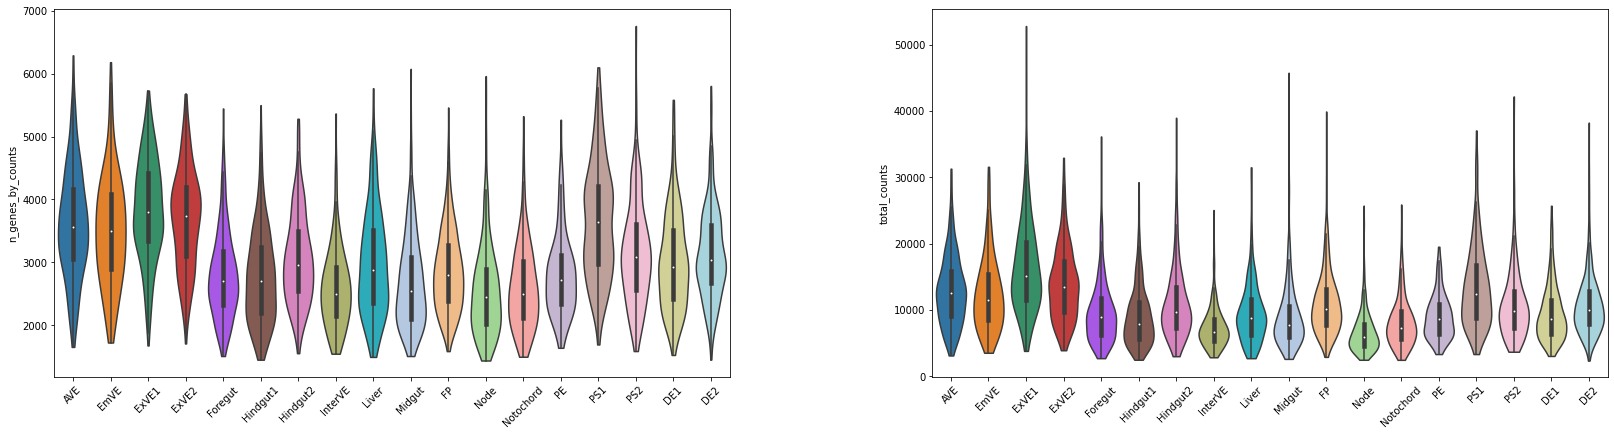

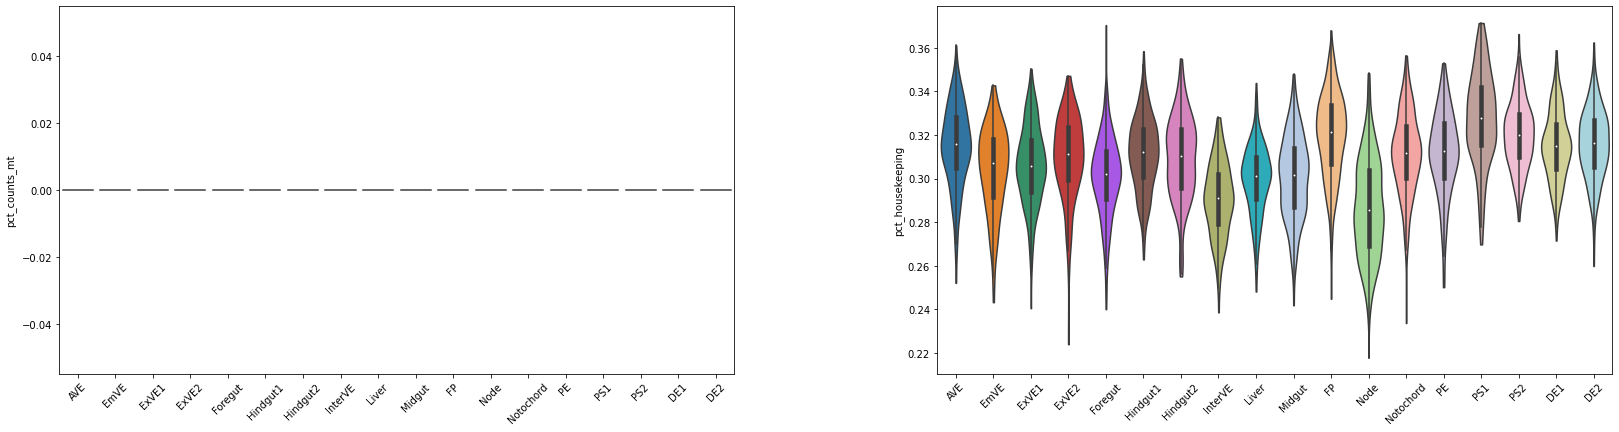

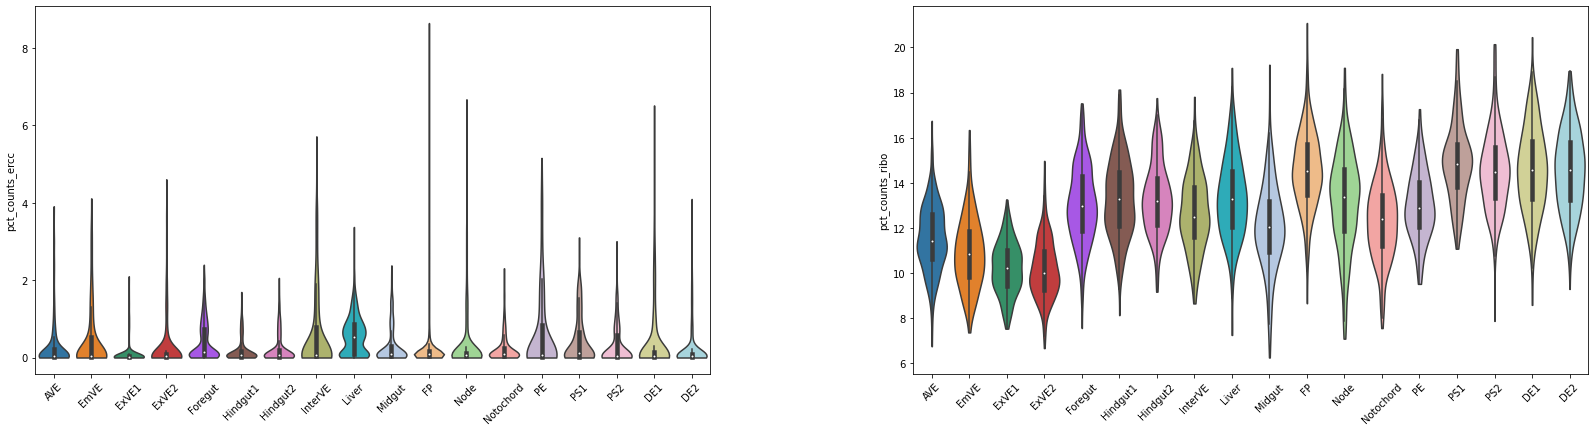

In [9]:
rcParams["figure.figsize"] = [10, 7]
sc.pl.violin(
    vivo,
    ["n_genes_by_counts", "total_counts"],
    groupby="cluster_names",
    jitter=0.4,
    multi_panel=True,
    stripplot=False,
    rotation=45,
    inner="box",
)
sc.pl.violin(
    vivo,
    ["pct_counts_mt", "pct_housekeeping"],
    groupby="cluster_names",
    jitter=0.4,
    multi_panel=True,
    stripplot=False,
    rotation=45,
    inner="box",
)
sc.pl.violin(
    vivo,
    ["pct_counts_ercc", "pct_counts_ribo"],
    groupby="cluster_names",
    jitter=0.4,
    multi_panel=True,
    stripplot=False,
    rotation=45,
    inner="box",
)

,index,Phase
0,G1,75
1,S,60
2,G2M,57


<AxesSubplot:xlabel='index', ylabel='Phase'>

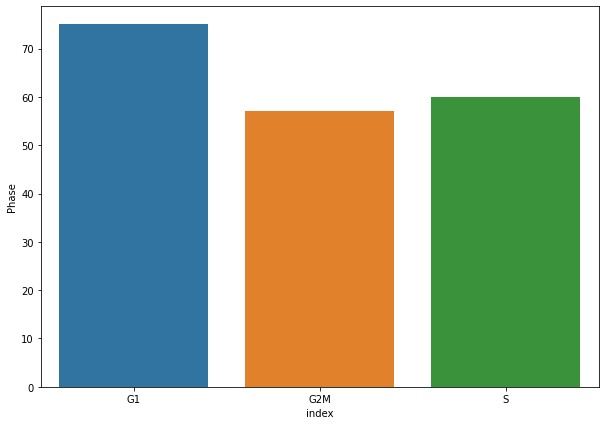

In [10]:
phase = pd.DataFrame(
    vivo[vivo.obs.cluster_names == "InterVE"].obs.Phase.value_counts()
).reset_index()
display(phase)

sns.barplot(x="index", y="Phase", data=phase)

## Percentage fraction

In [11]:
clusters = vivo.obs.cluster_names.value_counts().reset_index()

In [12]:
# colors.loc[clusters['index']]

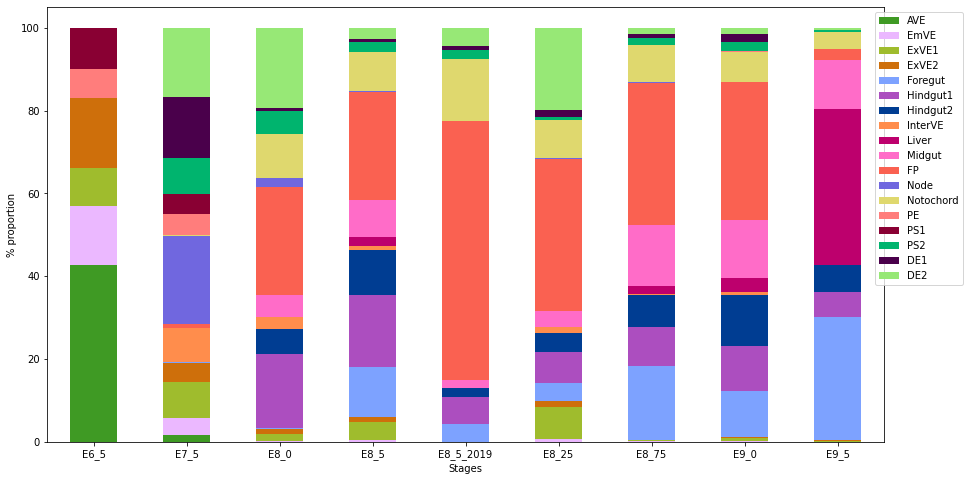

In [13]:
df = vivo.obs.groupby(["Stage", "cluster_names"]).count()[["orig.ident"]]
df = df.unstack().fillna(0)
df.columns = df.columns.droplevel()

# convert to percentage
df = df.div(df.sum(axis=1), axis=0) * 100

df.plot(
    kind="bar",
    stacked=True,
    figsize=[15, 8],
    #     cmap=cmap,
    rot=0,
    xlabel="Stages",
    ylabel="% proportion",
    color=colors.loc[df.columns, "Colour"].tolist(),
).legend(loc="upper right", bbox_to_anchor=(1.1, 1.0))
# plt.savefig("figures/barplot1.svg")

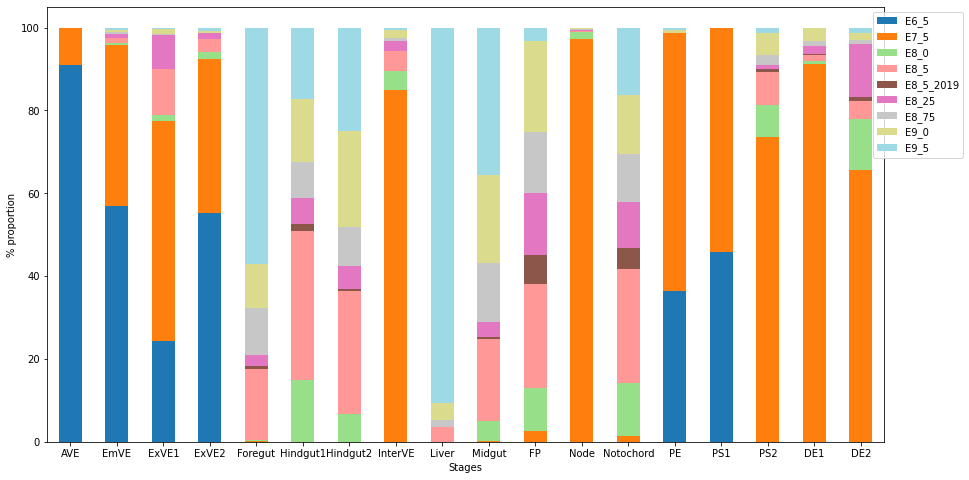

In [16]:
df = vivo.obs.groupby(["cluster_names", "Stage"]).count()[["orig.ident"]]
df = df.unstack().fillna(0)
df.columns = df.columns.droplevel()

# convert to percentage
df = df.div(df.sum(axis=1), axis=0) * 100

cmap = cm.get_cmap("tab20")
df.plot(
    kind="bar",
    stacked=True,
    figsize=[15, 8],
    cmap=cmap,
    rot=0,
    xlabel="Stages",
    ylabel="% proportion",
).legend(loc="upper right", bbox_to_anchor=(1.1, 1.0))
# plt.savefig("figures/barplot2.svg")

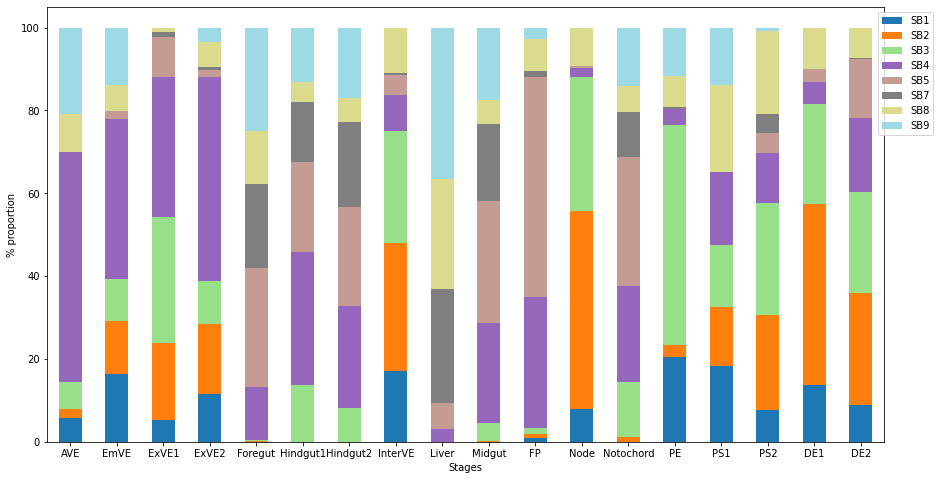

In [15]:
df = vivo.obs.groupby(["cluster_names", "Batch"]).count()[["orig.ident"]]
df = df.unstack().fillna(0)
df.columns = df.columns.droplevel()

# convert to percentage
df = df.div(df.sum(axis=1), axis=0) * 100

cmap = cm.get_cmap("tab20")
df.plot(
    kind="bar",
    stacked=True,
    figsize=[15, 8],
    cmap=cmap,
    rot=0,
    xlabel="Stages",
    ylabel="% proportion",
).legend(loc="upper right", bbox_to_anchor=(1.065, 1.0))

## Heatmap: Fig 3

- lysosome
- smad signaling
- lipid metabolism
- retinoid metabolism
- basement membrane
- hippo signaling
- fgf signaling
- wnt canonical signaling

In [24]:
import os

from scipy.cluster.hierarchy import leaves_list, ward
from scipy.spatial.distance import pdist


def nzm(adata):
    normalized = adata.copy()
    nzm = np.apply_along_axis(lambda v: np.median(v[np.nonzero(v)]), 0, adata.X)
    normalized.X /= nzm

    return normalized


def do_heatmap(adata, gene_file):
    filename: str = (
        os.path.basename(gene_file).capitalize().replace(".txt", "").replace("-", " ")
    )
    genes = pd.read_table(gene_file, header=None, index_col=0).index
    common_genes = np.intersect1d(adata.var_names, genes)
    clusters = [
        "ExVE1",
        "ExVE2",
        "EmVE",
        "AVE",
        "InterVE",
        "DE1",
        "DE2",
        "Hindgut1",
        "Hindgut2",
        "Midgut",
        "Foregut",
        "Liver"
    ]

    adata.obs.cluster_names = adata.obs.cluster_names.str.replace('pDE', 'eDE')
    sub = adata[adata.obs.cluster_names.isin(clusters), common_genes].copy()
    hclust = ward(pdist(sub.T.X))
    gene_order = common_genes[leaves_list(hclust)]

    sub.obs.cluster_names = sub.obs.cluster_names.astype('category').cat.reorder_categories(clusters)
    
    sc.pl.heatmap(
        sub,
        gene_order,
        groupby="cluster_names",
        figsize=[15, 5],
        standard_scale="var",
        swap_axes=True,
        show_gene_labels=False
    )

In [25]:
vivo = sc.read("../data/processed/01_raw_counts.h5ad")

metadata = pd.read_csv("../data/processed/02_metadata.csv", index_col=0)
vivo = vivo[metadata.index]
vivo.obs = metadata

sc.pp.normalize_total(vivo, target_sum=10_000)
sc.pp.log1p(vivo)
vivo.raw = vivo
sc.pp.scale(vivo, max_value=10)

# vivo = nzm(vivo)

../data/external/lysosome.txt


... storing 'orig.ident' as categorical
... storing 'Well_coordinates' as categorical
... storing 'Amp_batch_ID' as categorical
... storing 'Cell_barcode' as categorical
... storing 'Pool_barcode' as categorical
... storing 'Batch' as categorical
... storing 'Condition' as categorical
... storing 'SampleName' as categorical
... storing 'Stage' as categorical
... storing 'Source' as categorical
... storing 'SubGroup' as categorical
... storing 'Day' as categorical
... storing 'Phase' as categorical


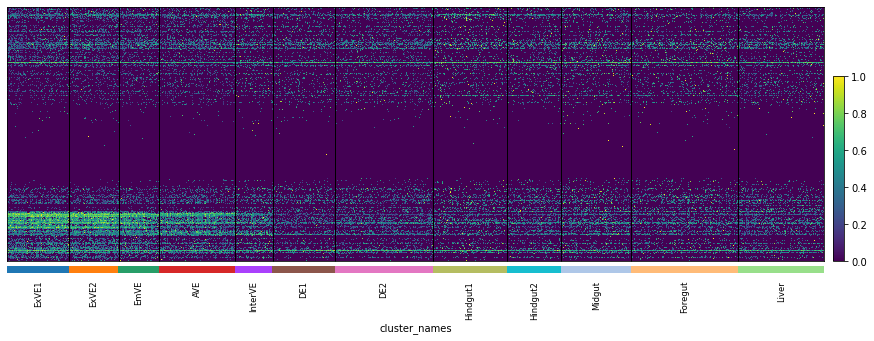

../data/external/pathway-Wnt-canonical.txt


... storing 'orig.ident' as categorical
... storing 'Well_coordinates' as categorical
... storing 'Amp_batch_ID' as categorical
... storing 'Cell_barcode' as categorical
... storing 'Pool_barcode' as categorical
... storing 'Batch' as categorical
... storing 'Condition' as categorical
... storing 'SampleName' as categorical
... storing 'Stage' as categorical
... storing 'Source' as categorical
... storing 'SubGroup' as categorical
... storing 'Day' as categorical
... storing 'Phase' as categorical


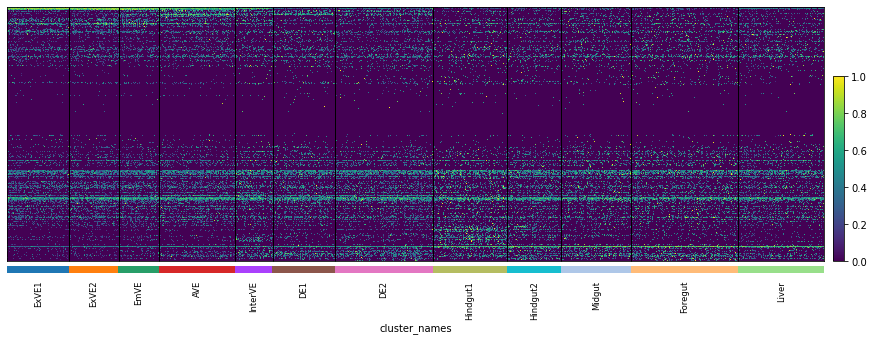

../data/external/pathway-smoothened.txt


... storing 'orig.ident' as categorical
... storing 'Well_coordinates' as categorical
... storing 'Amp_batch_ID' as categorical
... storing 'Cell_barcode' as categorical
... storing 'Pool_barcode' as categorical
... storing 'Batch' as categorical
... storing 'Condition' as categorical
... storing 'SampleName' as categorical
... storing 'Stage' as categorical
... storing 'Source' as categorical
... storing 'SubGroup' as categorical
... storing 'Day' as categorical
... storing 'Phase' as categorical


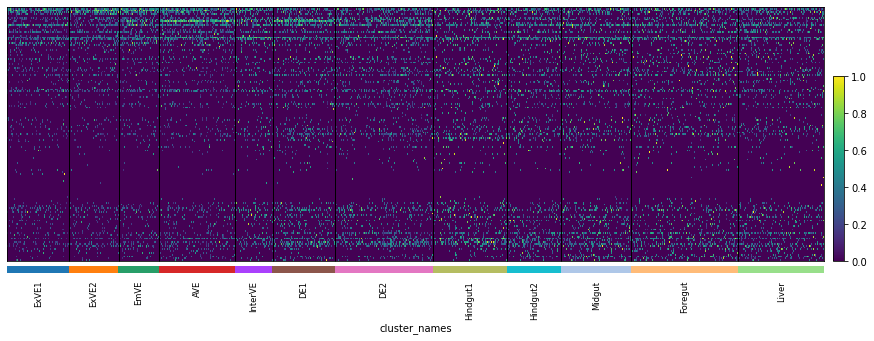

../data/external/pathway-smad.txt


... storing 'orig.ident' as categorical
... storing 'Well_coordinates' as categorical
... storing 'Amp_batch_ID' as categorical
... storing 'Cell_barcode' as categorical
... storing 'Pool_barcode' as categorical
... storing 'Batch' as categorical
... storing 'Condition' as categorical
... storing 'SampleName' as categorical
... storing 'Stage' as categorical
... storing 'Source' as categorical
... storing 'SubGroup' as categorical
... storing 'Day' as categorical
... storing 'Phase' as categorical


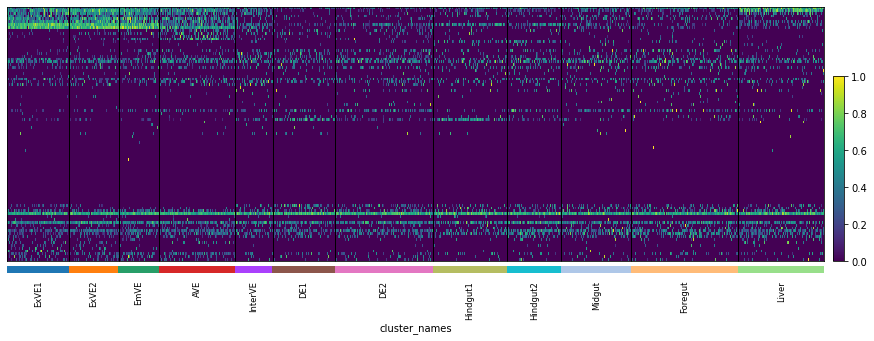

../data/external/metabolism-retinoid.txt


... storing 'orig.ident' as categorical
... storing 'Well_coordinates' as categorical
... storing 'Amp_batch_ID' as categorical
... storing 'Cell_barcode' as categorical
... storing 'Pool_barcode' as categorical
... storing 'Batch' as categorical
... storing 'Condition' as categorical
... storing 'SampleName' as categorical
... storing 'Stage' as categorical
... storing 'Source' as categorical
... storing 'SubGroup' as categorical
... storing 'Day' as categorical
... storing 'Phase' as categorical


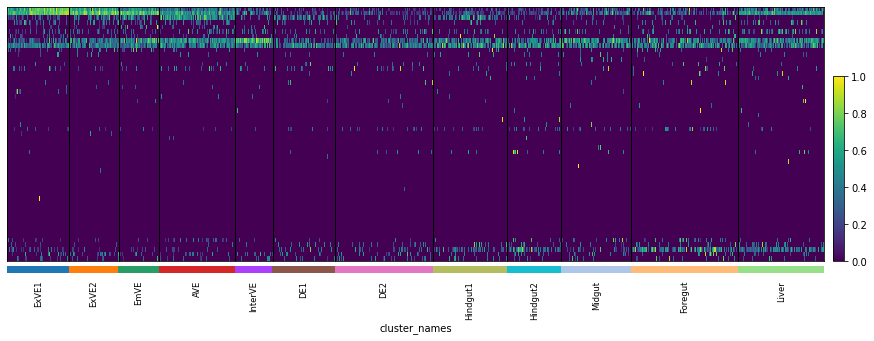

../data/external/pathway-hippo.txt


... storing 'orig.ident' as categorical
... storing 'Well_coordinates' as categorical
... storing 'Amp_batch_ID' as categorical
... storing 'Cell_barcode' as categorical
... storing 'Pool_barcode' as categorical
... storing 'Batch' as categorical
... storing 'Condition' as categorical
... storing 'SampleName' as categorical
... storing 'Stage' as categorical
... storing 'Source' as categorical
... storing 'SubGroup' as categorical
... storing 'Day' as categorical
... storing 'Phase' as categorical


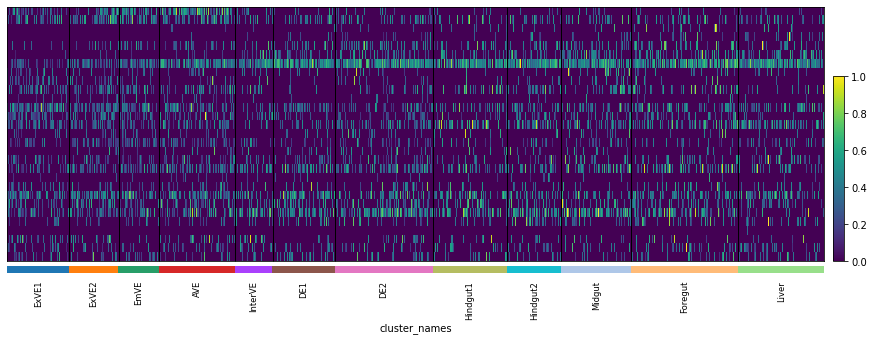

../data/external/pathway-fgf.txt


... storing 'orig.ident' as categorical
... storing 'Well_coordinates' as categorical
... storing 'Amp_batch_ID' as categorical
... storing 'Cell_barcode' as categorical
... storing 'Pool_barcode' as categorical
... storing 'Batch' as categorical
... storing 'Condition' as categorical
... storing 'SampleName' as categorical
... storing 'Stage' as categorical
... storing 'Source' as categorical
... storing 'SubGroup' as categorical
... storing 'Day' as categorical
... storing 'Phase' as categorical


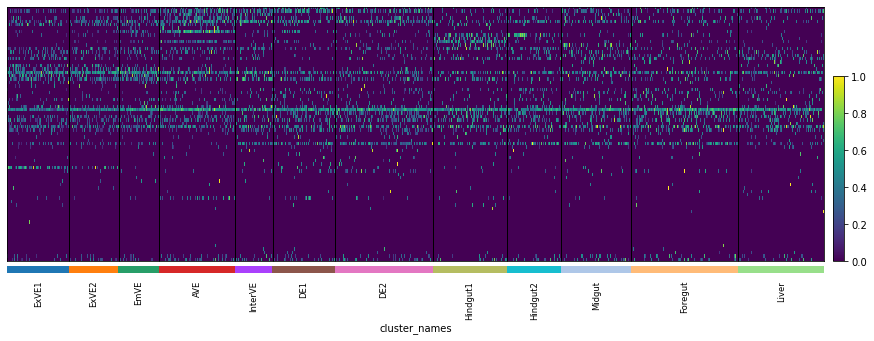

../data/external/ECM-basement membrane.txt


... storing 'orig.ident' as categorical
... storing 'Well_coordinates' as categorical
... storing 'Amp_batch_ID' as categorical
... storing 'Cell_barcode' as categorical
... storing 'Pool_barcode' as categorical
... storing 'Batch' as categorical
... storing 'Condition' as categorical
... storing 'SampleName' as categorical
... storing 'Stage' as categorical
... storing 'Source' as categorical
... storing 'SubGroup' as categorical
... storing 'Day' as categorical
... storing 'Phase' as categorical


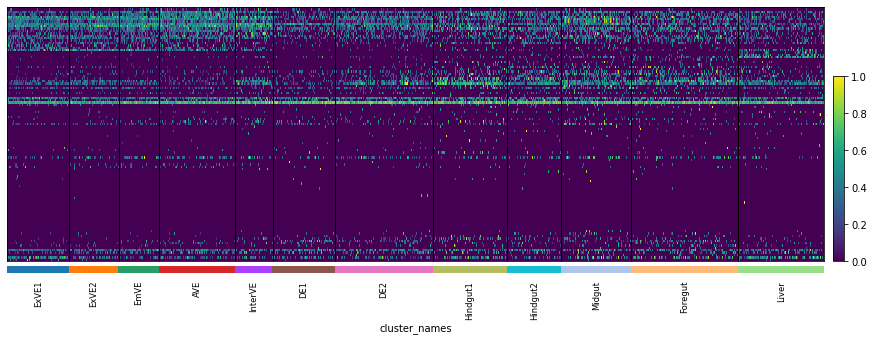

../data/external/metabolism-catabolic_lipid.txt


... storing 'orig.ident' as categorical
... storing 'Well_coordinates' as categorical
... storing 'Amp_batch_ID' as categorical
... storing 'Cell_barcode' as categorical
... storing 'Pool_barcode' as categorical
... storing 'Batch' as categorical
... storing 'Condition' as categorical
... storing 'SampleName' as categorical
... storing 'Stage' as categorical
... storing 'Source' as categorical
... storing 'SubGroup' as categorical
... storing 'Day' as categorical
... storing 'Phase' as categorical


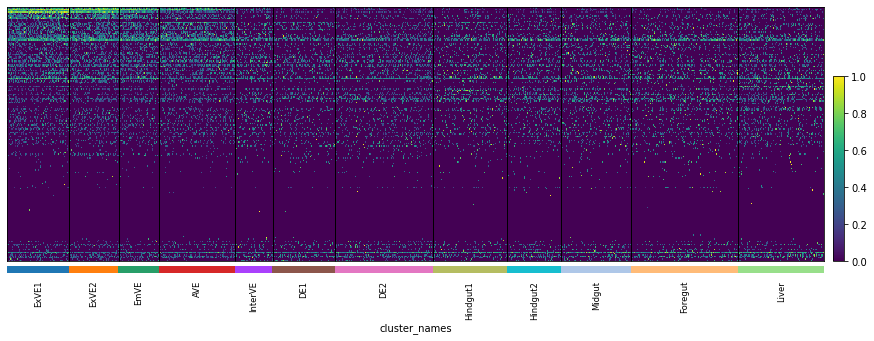

In [27]:
for ext_file in glob.glob("../data/external/*.txt"):
    print(ext_file)
    do_heatmap(vivo, ext_file)

## Dotplot

In [28]:
organoids = sc.read("../data/processed/06_rawcounts.h5ad")

organoids = organoids[metadata.index]
organoids.obs = metadata

organoids.obs.seurat_clusters = organoids.obs.seurat_clusters.astype("category")

sc.pp.normalize_total(organoids, target_sum=10_000)
sc.pp.log1p(organoids)
organoids.raw = organoids

... storing 'orig.ident' as categorical
... storing 'Well_coordinates' as categorical
... storing 'Amp_batch_ID' as categorical
... storing 'Cell_barcode' as categorical
... storing 'Pool_barcode' as categorical
... storing 'Batch' as categorical
... storing 'Condition' as categorical
... storing 'Stage' as categorical
... storing 'Source' as categorical
... storing 'SubGroup' as categorical
... storing 'Phase' as categorical


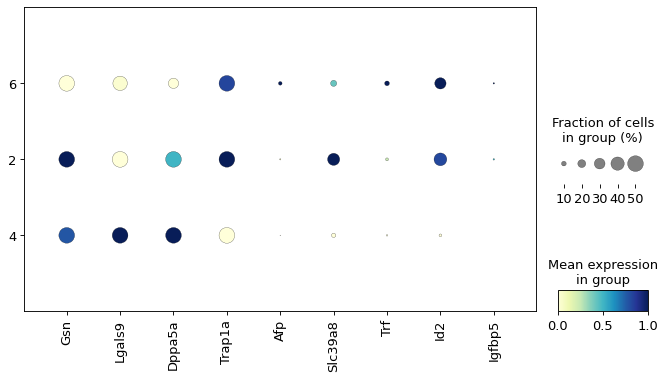

In [45]:
sc.set_figure_params(scanpy=True, fontsize=14)

#organoids_sub = organoids[organoids.obs.seurat_clusters.isin([2, 4, 6,1,5,0,3])].copy()
organoids_sub = organoids[organoids.obs.seurat_clusters.isin([2, 4, 6])].copy()
sc.pl.dotplot(
    organoids_sub,
    [
        "Gsn",
        "Lgals9",
        "Dppa5a",
        "Trap1a",
        "Afp",
        "Slc39a8",
        "Trf",
        "Id2",
        "Igfbp5",
    ],
    #categories_order=[6, 2,3, 4,1,5,0],
    categories_order=[6, 2, 4],
    groupby="seurat_clusters",
    standard_scale="var",
    # mean_only_expressed = True,
    dot_min=0,
    dot_max=0.5,
    cmap="YlGnBu",
    figsize=[10, 5],
    #save="dotplot_2.svg",
)

## Heatmap

In [30]:
our_genes = [
    "Tmsb10",
    "Trh",
    "Cpm",
    "Ifitm1",
    "Nid2",
    "Afp",
    "Sepp1",
    "Ctsh",
    "Trap1a",
    "Fmr1nb",
    "Myl6b",
    "Gsn",
    "Krt19",
    "Peg10",
    "Wfdc2",
    "Atp1b1",
    "Tmem37",
    "Tmem120a",
    "Ino80c",
    "Sat1",
    "Lgmn",
    "Slc39a8",
    "Apoe",
    "S100a10",
    "Tagln2",
] + ["T", "Foxa2"]

In [31]:
heat = vivo.copy()
heat = heat[heat.obs.Stage == "E7_5", our_genes]
heat = heat[~heat.obs.cluster_names.isin(["Midgut", "Foregut", "Notochord"])]
sc.pp.normalize_total(heat, target_sum=10_000)
sc.pp.log1p(heat)
heat.raw = heat
sc.pp.scale(heat, max_value=10)

/opt/conda/envs/cellrank-1.3.1/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/conda/envs/cellrank-1.3.1/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:354: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)


... storing 'orig.ident' as categorical
... storing 'Well_coordinates' as categorical
... storing 'Amp_batch_ID' as categorical
... storing 'Cell_barcode' as categorical
... storing 'Pool_barcode' as categorical
... storing 'Batch' as categorical
... storing 'Condition' as categorical
... storing 'Stage' as categorical
... storing 'Source' as categorical
... storing 'SubGroup' as categorical
... storing 'Day' as categorical
... storing 'Phase' as categorical
... storing 'cluster_names' as categorical


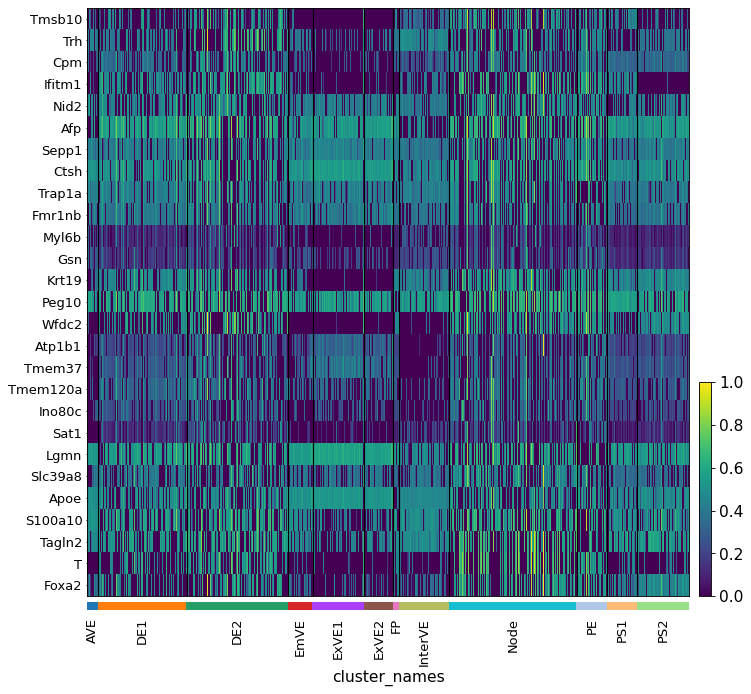

In [32]:
sc.pl.heatmap(
    heat,
    heat.var_names,
    groupby="cluster_names",
    standard_scale="var",
    figsize=[10, 10],
    dendrogram=False,
    swap_axes=True,
#     save="heatmap.svg",
)

## InterVE Heatmap

In [35]:
vivo = sc.read("../data/processed/01_raw_counts.h5ad")
metadata = pd.read_csv("../data/processed/02_metadata.csv", index_col=0)
vivo = vivo[metadata.index]
vivo.obs = metadata

rename_clusters(vivo)

sc.pp.normalize_total(vivo, target_sum=10_000)
sc.pp.log1p(vivo)
vivo.raw = vivo
vivo = vivo[
    vivo.obs.cluster_names.isin(["AVE", "EmVE", "ExVE1", "ExVE2", "DE2", "InterVE"])
]

vivo.obs["type_like"] = "DE2"
vivo.obs.loc[vivo.obs.cluster_names == "InterVE", "type_like"] = "InterVE"
vivo.obs.loc[
    vivo.obs.cluster_names.isin(["AVE", "EmVE", "ExVE1", "ExVE2"]), "type_like"
] = "VE_LIKE"
vivo.obs["type_like"] = vivo.obs["type_like"].astype("category")

Trying to set attribute `.obs` of view, copying.


In [36]:
# get markers
sc.tl.rank_genes_groups(
    vivo,
    "type_like",
    groups=["DE2"],
    reference="InterVE",
    method="wilcoxon",
    key_added="inter_vs_pde",
    rankby_abs=False,
)
sc.tl.rank_genes_groups(
    vivo,
    "type_like",
    groups=["VE_LIKE"],
    reference="InterVE",
    method="wilcoxon",
    key_added="inter_vs_ve",
    rankby_abs=False,
)

... storing 'orig.ident' as categorical
... storing 'Well_coordinates' as categorical
... storing 'Amp_batch_ID' as categorical
... storing 'Cell_barcode' as categorical
... storing 'Pool_barcode' as categorical
... storing 'Batch' as categorical
... storing 'Condition' as categorical
... storing 'Stage' as categorical
... storing 'Source' as categorical
... storing 'SubGroup' as categorical
... storing 'Day' as categorical
... storing 'Phase' as categorical
